# Emotion Classification from Faces with CNN & PyTorch - Part 4

In this series we will continue builind a model that will guess the emotion of a person from a facial expression. We will add techniques such as batch normalization and hyperparameters tuning, and add layers to make more advance models compared to part one.

The model will be trained only with the seven basic emtotions identified by Ekman: anger, disgust, contempt, happiness, sadness, fear, surprise.

Moreover, the model will look only at photos of real people (no cartoon or generated images), to capture microexpressions, which are crucual to give high accuracy to such a model. In fact, humans heavily rely on microexpressions to distinguish between different emotions in the arc of milliseconds (e.g., fear from surprise, disgust from contempt), and taking those out of the equations would mean removing key elememnts. A challenge might be increasing the quality of the images used for training, then burdening the computational power with an heavier dataset. Feature engineering might be key in selecting the parts of the images that are the most relevant, eliminating everything else.

Finally we will build different Convolutional Neural Networks and evaluate the different models. Since the whole process will take a significant amount of code, the work will be divided into different notebooks linking to each other.

The first notebook focused in loading, cleaning, and augmenting the data. Whereas the first part of the modelling testes different combinations of models and make observations.
- [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda)
- [Emotion_Classification_from_Faces_with_CNN_Part_1](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-pytorch-1)
- [Emotion_Classification_from_Faces_with_CNN_Part_2](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-with-cnn-part-2)
- [Emotion_Classification_from_Faces_with_CNN_Part_3](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-cnn-part-3)

Since we have already loaded, cleaned, and inspected the data in our previous notebook [Emotion Recognition from Faces with CNN - Exploratory Data Analysis (EDA)](https://www.kaggle.com/code/gabrielenoaro/emotion-recognition-from-faces-with-cnn-eda), we will jump directly to data preprocessing.

In this notebook we to apply grid search, stratified K fold validation, and schedule learning to improve hyperparameters tuning from on the model selected in the last notebook: [Emotion_Classification_from_Faces_with_CNN_Part_3](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-cnn-part-3).

## Table of contents

1. [Load the libraries](#load-the-data)
2. [Helper functions for data processing](#helper-functions-for-data-proccessing)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Data preprocessing, splitting, and augmentation](#data-preprocessing-splitting-and-augmentation)

3. [Split the data](#split-the-data)
4. [Build the models](#build-the-models)    
5. [Train and test the models](#train-and-test-the-models)

    5.1 [Define the hyperparameters](#define-the-hyperparameters)

    5.2 [Helper functions for training, testing, and plotting](#helper-functions-for-training-testing-and-plotting)
    
    5.3 [Train the models](#train-the-models)
    
    5.4 [Test the models](#test-the-models)

    5.5 [Table with the results of the different models](#table-with-the-results-of-the-different-models)

    5.6 [Confusion matrix of the best model](#confusion-matrix-of-the-best-model)

6. [Conclusions](#conclusions)

    6.1 [Observations](#observations)

    6.2 [Lessons learned](#lessons-learned)

    6.3 [Limitations with the data](#limitations-with-the-data)

    6.4 [Next steps](#next-steps)

## Load the libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle
import random
from hashlib import md5
import matplotlib.pyplot as plt
import copy

from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, StratifiedKFold

import os,cv2
from PIL import Image
from collections import Counter

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torchsummary import summary


We want also to set a random seed to maintain consistency across our experiments.

In [2]:
#Cover all the potential cases with the random seed
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior.
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

## Helper functions for data prerocessing

In [3]:
def print_image_info(images, labels, stage):
    unique_labels = set(labels)
    print(f"Stage: {stage}")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Image dtype: {images[0].dtype}")
    print(f"Unique labels: {unique_labels}")
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        if label_images:
            print(f"Class: {label}, Image shape: {label_images[0].shape}, dtype: {label_images[0].dtype}, min: {label_images[0].min()}, max: {label_images[0].max()}")

#### Perform random data reduction on overrepresented classes

In [4]:
def reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    print_image_info(img_data, img_labels, "After loading in reduce_majority_classes")

    reduced_data = []
    reduced_labels = []
    label_counts = Counter(img_labels)

    for label in np.unique(img_labels):
        label_indices = np.where(img_labels == label)[0]
        if label_counts[label] > max_samples_per_class:
            label_indices = np.random.choice(label_indices, max_samples_per_class, replace=False)

        reduced_data.extend(img_data[label_indices])
        reduced_labels.extend(img_labels[label_indices])

    reduced_data = np.array(reduced_data)
    reduced_labels = np.array(reduced_labels)

    print_image_info(reduced_data, reduced_labels, "Before saving in reduce_majority_classes")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((reduced_data, reduced_labels), f)




#### Preprocess and transform the data

In [5]:
#Preprocess data
def load_and_preprocess_images(input_pickle_file, output_pickle_file):
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Convert images to float32
    processed_images = [img.astype('float32') for img in img_data]
    processed_images = np.array(processed_images)
    
    print_image_info(processed_images, img_labels, "Preprocessed")

    with open(output_pickle_file, 'wb') as f:
        pickle.dump((processed_images, img_labels), f)

#### Encode the labels

In [6]:
def encode_labels(input_pickle_file, output_pickle_file, label_mapping_file):
    # Load the data from the pickle file
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Print initial info
    print_image_info(img_data, img_labels, "After loading in encode_labels")

    # Check unique labels
    unique_labels = set(img_labels)
    print(f"Unique labels before encoding: {unique_labels}")

    # Encode labels
    sorted_labels = sorted(unique_labels)
    label_to_int = {label: idx for idx, label in enumerate(sorted_labels)}
    img_labels_int = np.array([label_to_int[label] for label in img_labels])

    # Convert labels to long type
    img_labels_int = img_labels_int.astype(np.int64)

    # Check encoded labels
    unique_encoded_labels = set(img_labels_int)
    print(f"Unique labels after encoding: {unique_encoded_labels}")

    # Save encoded data
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((img_data, img_labels_int), f)

    # Save label mappings
    label_mapping = {'label_to_int': label_to_int, 'int_to_label': {v: k for k, v in label_to_int.items()}}
    with open(label_mapping_file, 'wb') as f:
        pickle.dump(label_mapping, f)

    # Print final info
    print_image_info(img_data, img_labels_int, "After encoding labels")
    print("Label mapping saved:")
    print(label_mapping)


#### Visualize image

In [7]:
def visualize_sample_images(images, labels, label_mapping, title):
    fig, axs = plt.subplots(1, len(label_mapping), figsize=(15, 7))
    class_to_images = {}
    for img, label in zip(images, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        img = img.squeeze()
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {label_mapping[label]}")
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Count and Plot the number of itmes for each class

In [10]:
# Helper function to count and plot the items for each label
def count_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)
    
    # Print the counts for each label
    for label, count in zip(unique_labels, counts):
        print(f'Label {label}: {count} items')

In [11]:
#Helper function to cont and plot the items for each label
def plot_items_in_classes(dataset_file):
    # Load the pickled data
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Count the occurrences of each label
    unique_labels, counts = np.unique(img_labels, return_counts=True)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Emotion Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Verify the correctness of the labels

In [12]:
def verify_images(dataset_file):
    with open(dataset_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)

    # Load the label mappings
    label_mapping_file = 'label_mapping.pkl'
    with open(label_mapping_file, 'rb') as f:
        label_mapping = pickle.load(f)
    int_to_label = label_mapping['int_to_label']

    # Organize images by class
    class_to_images = {}
    for img, label in zip(img_data, img_labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img)

    # Plot one sample image for each class
    num_classes = len(class_to_images)
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

    for i, (label, images) in enumerate(class_to_images.items()):
        img = random.choice(images)
        
        # Ensure the image values are in [0, 1]
        img = np.clip(img, 0.0, 1.0)
        
        # If the image has a singleton dimension, squeeze it
        if img.shape[0] == 1:
            img = img.squeeze(0)
        else:
            img = img.squeeze()
        
        # Debugging: Print image information
        print(f"Class: {int_to_label[label]}, Image shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

        # Display the image
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Class: {int_to_label[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### Remove classes from the dataset

In [13]:
def remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove):
    # Load the pickled data
    with open(input_pickle_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Create lists to store the filtered data
    filtered_img_data = []
    filtered_img_labels = []
    
    # Remove specified classes from the dataset
    for img, label in zip(img_data, img_labels):
        if label not in classes_to_remove:
            filtered_img_data.append(img)
            filtered_img_labels.append(label)
    
    # Convert lists to numpy arrays
    filtered_img_data = np.array(filtered_img_data, dtype=np.float32)
    filtered_img_labels = np.array(filtered_img_labels, dtype=img_labels.dtype)
    
    # Save the filtered dataset to a new pickle file
    with open(output_pickle_file, 'wb') as f:
        pickle.dump((filtered_img_data, filtered_img_labels), f)
    
    print(f"Dataset without classes {classes_to_remove} saved to {output_pickle_file}")



## Exploratory Data Analysis

In [4]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Contempt: 73 items
Label Disgust: 743 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


Disgust and especially Contempt are extremely underepresented classes, therefore we either need to dramatically reduce the size of all classes to fewer than 1000 or perhaps 500 images, find new images, or remove Contempt and Disgust from this particular experiment.

Let's remove Disgust and Contempt because they are to underrepresented.

In [22]:
input_pickle_file = 'images_labels_no_duplicates.pkl'
output_pickle_file = 'images_labels_no_duplicates_no_dis_cont.pkl'
classes_to_remove = ['Disgust', 'Contempt']

remove_classes_and_save(input_pickle_file, output_pickle_file, classes_to_remove)

Dataset without classes ['Disgust', 'Contempt'] saved to images_labels_no_duplicates_no_dis_cont.pkl


In [23]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

count_items_in_classes(dataset_file)

Label Anger: 4977 items
Label Fear: 5003 items
Label Happiness: 9111 items
Label Neutral: 6155 items
Label Sadness: 6100 items
Label Surprise: 3599 items


The Disgust and Contempt classes have been removed successfully, and the new dataset has been saved in a pickle file.

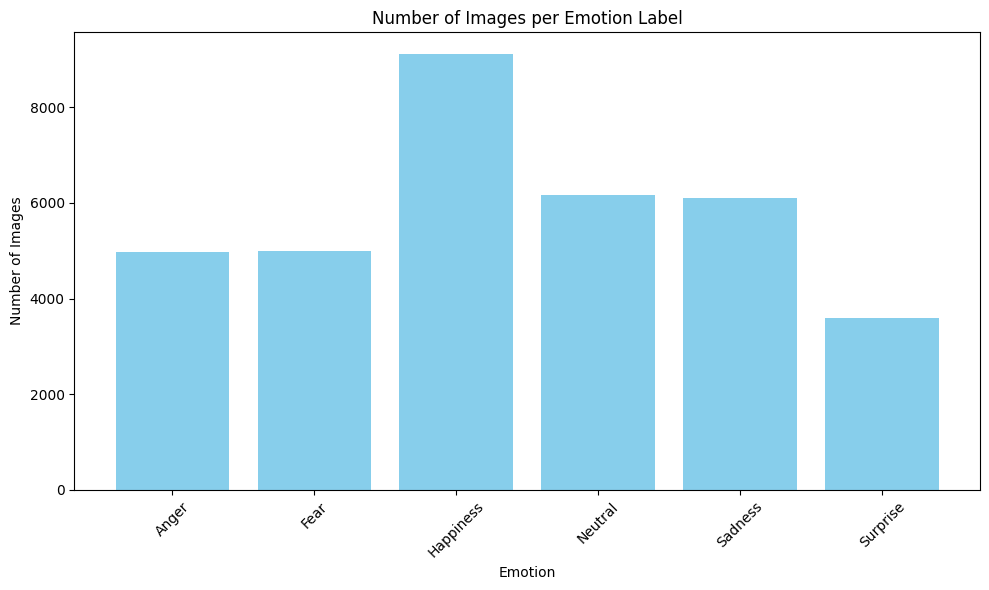

In [24]:
# Specify the input dataset file
dataset_file = 'images_labels_no_duplicates_no_dis_cont.pkl'

# Execute the verification function
plot_items_in_classes(dataset_file)

We could use the new function to randomly reduce the number of items in the Happiness class so it equals the Neutral class, then we can augment all classes to reach a cerain number of images.

## Data preprocessing

#### Random data reduction to reduce class imbalances

Even if random data reduction on majority classes would make classes much more balanced, we tested the smaller dataset, and the model underfits the data. There is why we are going to train with a bigger dataset for the moment, even if classes are less balanced.

In [ ]:
input_pickle_file = "images_labels_no_duplicates_no_dis_cont.pkl"
output_pickle_file = "reduced_images_3.pkl"
#max_samples_per_class = 5003
max_samples_per_class = 9111

#Reduce majority classes
reduce_majority_classes(input_pickle_file, output_pickle_file, max_samples_per_class)

#### Process and transform the data

In [ ]:
input_pickle_file = "reduced_images_3.pkl"
output_pickle_file = "processed_images_3.pkl"

load_and_preprocess_images(input_pickle_file, output_pickle_file)

#### Encode labels

In [5]:
#input_pickle_file = "reduced_images_3.pkl"
input_pickle_file = 'processed_images_3.pkl'
output_pickle_file = 'encoded_images.pkl'
label_mapping = 'label_mapping.pkl'
encode_labels(input_pickle_file, output_pickle_file, label_mapping)


Stage: After loading in encode_labels
Number of images: 34945
Number of labels: 34945
Image shape: (48, 48)
Image dtype: float32
Unique labels: {'Sadness', 'Happiness', 'Surprise', 'Anger', 'Neutral', 'Fear'}
Class: Sadness, Image shape: (48, 48), dtype: float32, min: 0.0, max: 0.8470588326454163
Class: Happiness, Image shape: (48, 48), dtype: float32, min: 0.23137255012989044, max: 0.843137264251709
Class: Surprise, Image shape: (48, 48), dtype: float32, min: 0.06666667014360428, max: 1.0
Class: Anger, Image shape: (48, 48), dtype: float32, min: 0.04313725605607033, max: 0.8196078538894653
Class: Neutral, Image shape: (48, 48), dtype: float32, min: 0.05098039284348488, max: 0.9725490212440491
Class: Fear, Image shape: (48, 48), dtype: float32, min: 0.0, max: 1.0
Unique labels before encoding: {'Sadness', 'Happiness', 'Surprise', 'Anger', 'Neutral', 'Fear'}
Unique labels after encoding: {0, 1, 2, 3, 4, 5}
Stage: After encoding labels
Number of images: 34945
Number of labels: 34945
Imag

## Build the models

We are loading the architectures of the best performing models of our [previous notebook](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-cnn-part-3).

#### Model 33

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 6)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [9]:
model_33 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

#### Model 39

In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [35]:
model_39 = CNNModel()

# Select between 'cpu' or 'cuda' to access GPU
#device = 'cpu' # Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_39.to(device)

# Summarize the model
summary(model_39, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 48, 48]             320
       BatchNorm2d-2            [1, 32, 48, 48]              64
         MaxPool2d-3            [1, 32, 24, 24]               0
            Conv2d-4            [1, 64, 24, 24]          18,496
       BatchNorm2d-5            [1, 64, 24, 24]             128
         MaxPool2d-6            [1, 64, 12, 12]               0
 AdaptiveAvgPool2d-7              [1, 64, 1, 1]               0
            Linear-8                    [1, 32]           2,080
            Linear-9                     [1, 6]             198
Total params: 21,286
Trainable params: 21,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.90
Params size (MB): 0.08
Estimated Total Size (MB): 1.99
----------------------------------------

## Helper functions for training, testing, and plotting

Since with stratified K-fold validation the data is split and augmented during training, we moved the related helper functions from the [preprocessing](#helper-functions-for-data-prerocessing) section to training section, to facilitate debugging.

#### Define the custom dataset class

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    

#### Conversions for stratified K fold validation

In [11]:
def convert_to_pil_format(images):
    return [Image.fromarray((img * 255).astype(np.uint8), mode='L') for img in images]

def convert_to_numpy_array(img_data_pil):
    img_data_numpy = []
    for img_pil in img_data_pil:
        img_numpy = np.array(img_pil).astype('float32') / 255.0  # Normalize to [0, 1]
        if img_numpy.ndim == 2:
            img_numpy = np.expand_dims(img_numpy, axis=0)  # Add channel dimension
        elif img_numpy.ndim == 3 and img_numpy.shape[2] == 1:
            img_numpy = np.squeeze(img_numpy, axis=2)
            img_numpy = np.expand_dims(img_numpy, axis=0)
        img_numpy = np.clip(img_numpy, 0.0, 1.0)  # Ensure values are in [0, 1]
        img_data_numpy.append(img_numpy)
    return img_data_numpy



def convert_to_tensors(images, labels):
    all_images_tensor = torch.tensor(images, dtype=torch.float32)
    all_labels_tensor = torch.tensor(labels, dtype=torch.int64)
    dataset = TensorDataset(all_images_tensor, all_labels_tensor)
    return dataset



#### Augmentation & balancing for stratified K fold

In [12]:

data_transforms = transforms.Compose([
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0))
])


def augment_images(img_data_pil, target_count):
    augmented_images_pil = []
    while len(augmented_images_pil) + len(img_data_pil) < target_count:
        for img_pil in img_data_pil:
            if len(augmented_images_pil) + len(img_data_pil) >= target_count:
                break
            augmented_img_pil = data_transforms(img_pil)
            augmented_images_pil.append(augmented_img_pil)
    print_image_info(augmented_images_pil, [None]*len(augmented_images_pil), "Augmented")
    return augmented_images_pil

def balance_dataset(img_data, img_labels, target_number_of_images):
    img_data_dict = {label: [] for label in set(img_labels)}
    for img, label in zip(img_data, img_labels):
        img_data_dict[label].append(img)
        
    balanced_img_data_dict = {}
    for label, img_list in img_data_dict.items():
        print(f'Processing {label}, {len(img_list)} images')
        if len(img_list) < target_number_of_images:
            augmented_imgs = augment_images(img_list, target_number_of_images)
            balanced_img_data_dict[label] = img_list + [np.array(img).astype('float32') / 255.0 for img in augmented_imgs]
        else:
            balanced_img_data_dict[label] = img_list
            
    balanced_img_data = []
    balanced_img_labels = []
    for label, imgs in balanced_img_data_dict.items():
        balanced_img_data.extend(imgs)
        balanced_img_labels.extend([label] * len(imgs))
        
    return balanced_img_data, balanced_img_labels

#### Train and cross validation

In [13]:
def train_model(model, model_name, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs, patience, checkpoint_interval):
    model = model.to(device)
    model.train()  # Set the model to training mode

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        train_accuracies.append(epoch_train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]}, Accuracy: {epoch_train_accuracy}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Validation Loss: {val_losses[-1]}, Accuracy: {epoch_val_accuracy}%')

        # Step the scheduler
        scheduler.step()

        # Check for early stopping
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience and epoch_train_accuracy > epoch_val_accuracy:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement for {patience} epochs and training accuracy higher than validation accuracy.")
            break

        # Save model checkpoint every checkpoint_interval epochs
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'{model_name}_checkpoint_epoch_{epoch + 1}.pth'
            torch.save(model.state_dict(), checkpoint_filename)
            print(f'Checkpoint saved at epoch {epoch + 1}')

    # Load the best model weights before early stopping
    model.load_state_dict(best_model_wts)

    # Save the best model weights
    model_filename = f'{model_name}_best_model.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Best model saved as {model_filename}')

    # Save the accuracies and model name
    with open(f'{model_name}_accuracies.pkl', 'wb') as f:
        pickle.dump((model_name, train_accuracies, val_accuracies, val_losses, train_losses), f)

    return train_losses, train_accuracies, val_losses, val_accuracies

In [19]:
# Print image info for debugging
def print_image_info(img_data, img_labels, stage):
    print(f"Stage: {stage}")
    print(f"Number of images: {len(img_data)}")
    print(f"Number of labels: {len(img_labels)}")
    
    if len(img_data) > 0:
        if isinstance(img_data[0], np.ndarray):
            print(f"Image shape: {img_data[0].shape}")
            img_data_np = np.stack(img_data)
            print(f"Image data min value: {np.min(img_data_np)}")
            print(f"Image data max value: {np.max(img_data_np)}")
            print(f"Image data mean: {np.mean(img_data_np)}")
            print(f"Image data std: {np.std(img_data_np)}")
        else:
            print(f"Image size: {img_data[0].size}")
            print(f"Image mode: {img_data[0].mode}")
    
    print(f"Unique labels: {set(img_labels)}")


In [27]:
# Helper function to print sample data for debugging
def print_sample_data(images, labels, title):
    print(f"--- {title} ---")
    sample_indices = random.sample(range(len(images)), min(5, len(images)))
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))
    for i, ax in enumerate(axes):
        index = sample_indices[i]
        ax.imshow(images[index], cmap='gray')
        ax.set_title(f"Label: {labels[index]}")
        ax.axis('off')
    plt.show()

In [30]:
def main(data_file, model_instance, model_name, criterion, optimizer_class, param_grid, device, num_epochs, patience, checkpoint_interval, k=5, target_number_of_images=8000):
    # Load the dataset
    with open(data_file, 'rb') as f:
        img_data, img_labels = pickle.load(f)
    
    # Print initial info
    print_image_info(img_data, img_labels, "After loading in main")
    print_sample_data(img_data, img_labels, "Sample images after loading")
    
    # Convert the entire dataset to PIL format
    img_data_pil = convert_to_pil_format(img_data)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    all_fold_results = []

    # Stratified K-Fold Cross-Validation
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(img_data_pil, img_labels)):
        train_data, train_labels = [img_data_pil[i] for i in train_idx], [img_labels[i] for i in train_idx]
        test_data, test_labels = [img_data_pil[i] for i in test_idx], [img_labels[i] for i in test_idx]

        # Balance the training dataset
        balanced_train_data, balanced_train_labels = balance_dataset(train_data, train_labels, target_number_of_images)

        # Print info after balancing
        print_image_info(balanced_train_data, balanced_train_labels, "After balancing")
        print_sample_data(balanced_train_data, balanced_train_labels, "Sample images after balancing")

        # Split into training and validation sets
        val_size = int(0.2 * len(balanced_train_data))
        train_data, val_data = balanced_train_data[val_size:], balanced_train_data[:val_size]
        train_labels, val_labels = balanced_train_labels[val_size:], balanced_train_labels[:val_size]

        # Convert back to NumPy arrays for consistent processing
        train_data = convert_to_numpy_array(train_data)
        val_data = convert_to_numpy_array(val_data)
        test_data = convert_to_numpy_array(test_data)

        # Print info after conversion back to NumPy
        print_image_info(train_data, train_labels, "After conversion back to NumPy")
        #print_sample_data(train_data, train_labels, "Sample images after conversion back to NumPy")

        # Create datasets
        train_dataset = CustomDataset(train_data, train_labels)
        val_dataset = CustomDataset(val_data, val_labels)
        test_dataset = CustomDataset(test_data, test_labels)

        # Create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        best_val_accuracy = 0.0
        best_model = None
        best_params = None

        # Hyperparameter tuning
        for params in ParameterGrid(param_grid):
            # Create a fresh copy of the model instance for each set of parameters
            model = copy.deepcopy(model_instance).to(device)
            optimizer_params = {k: v for k, v in params.items() if k in ['lr', 'momentum', 'weight_decay', 'betas']}
            optimizer = optimizer_class(model.parameters(), **optimizer_params)

            # Initialize scheduler
            scheduler_params = {k: v for k, v in params.items() if k in ['step_size', 'gamma']}
            scheduler = StepLR(optimizer, **scheduler_params)

            print(f"Training with parameters: {params}")
            train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                model, f"{model_instance.__class__.__name__}_fold_{fold_idx}", criterion, optimizer, scheduler,
                train_loader, val_loader, device, num_epochs, patience, checkpoint_interval
            )

            if max(val_accuracies) > best_val_accuracy:
                best_val_accuracy = max(val_accuracies)
                best_model = copy.deepcopy(model)
                best_params = params

        # Evaluate the best model on the test set
        best_model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = best_model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        all_fold_results.append((best_val_accuracy, test_accuracy, best_params))
        print(f"Fold {fold_idx + 1}: Best Validation Accuracy: {best_val_accuracy}%, Test Accuracy: {test_accuracy}%")

    # Save all fold results
    with open(f'{model_name}_cross_validation_results.pkl', 'wb') as f:
        pickle.dump(all_fold_results, f)

    print(f"Cross-validation results saved to '{model_name}_cross_validation_results.pkl'.")


#### Plot the performance of the training across epochs

In [22]:
# Plot the model performance after training
def plot_training_progress(training_results):
  
    """
    Plot training and validation accuracies across epochs for multiple models.

    Args:
    - training_results (list of tuples): List of tuples containing model names and their respective training and validation accuracies.
      Each tuple should be in the form: (model_name, train_accuracies, val_accuracies).
    """
    plt.figure(figsize=(10, 5))
    
    # Plot training and validation accuracies
    for result in training_results:
        model_name, train_accuracies, val_accuracies = result
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label=f'Training Accuracy - {model_name}')
        plt.plot(epochs, val_accuracies, label=f'Validation Accuracy - {model_name}')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    

## Train the models

#### Train model_33

In [ ]:
if __name__ == "__main__":
    data_file = "encoded_images.pkl"
    model_instance = model_33
    model_name = "model_33"
    criterion = nn.CrossEntropyLoss()
    #optimizer_class = optim.Adam
    optimizer_class = torch.optim.Adam
    param_grid = {
        'lr': [0.01, 0.005, 0.001, 0.0005],
        #'momentum': [0.9, 0.95], # For optimizers like SGD
        'weight_decay': [0.001, 0.0005, 0.0001, 0.00005, 0.00001],
        'betas': [(0.9, 0.999), (0.95, 0.999)],  # For optimizers like Adam
        'step_size': [10, 20],  # Parameters for StepLR scheduler
        'gamma': [0.1, 0.5]     # Parameters for StepLR scheduler
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 200
    patience = 5
    checkpoint_interval = 100

    main(data_file, model_instance, model_name, criterion, optimizer_class, param_grid, device, num_epochs, patience, checkpoint_interval, k=5, target_number_of_images=8000)


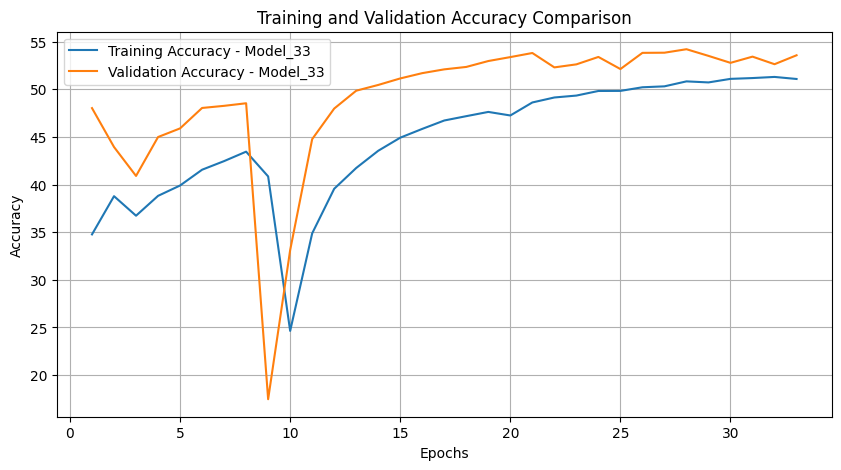

In [32]:
model_name ="Model_33"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

#### Model 39

In [ ]:
if __name__ == "__main__":
    data_file = "encoded_images.pkl"
    model_instance = model_33
    model_name = "model_39"
    criterion = nn.CrossEntropyLoss()
    #optimizer_class = optim.Adam
    optimizer_class = torch.optim.Adam
    param_grid = {
        'lr': [0.01, 0.005, 0.001, 0.0005],
        #'momentum': [0.9, 0.95], # For optimizers like SGD
        'weight_decay': [0.001, 0.0005, 0.0001, 0.00005, 0.00001],
        'betas': [(0.9, 0.999), (0.95, 0.999)],  # For optimizers like Adam
        'step_size': [10],  # Parameters for StepLR scheduler
        'gamma': [0.1, 0.5]     # Parameters for StepLR scheduler
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 200
    patience = 3
    checkpoint_interval = 100

    main(data_file, model_instance, model_name, criterion, optimizer_class, param_grid, device, num_epochs, patience, checkpoint_interval, k=5, target_number_of_images=8000)

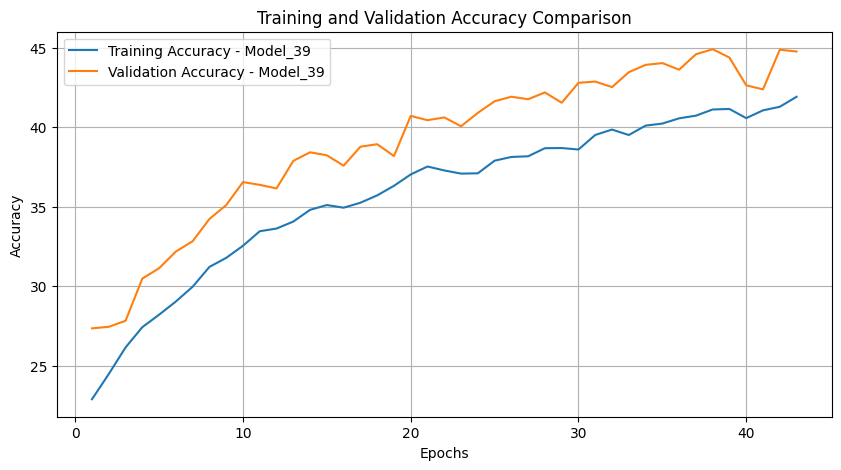

In [37]:
model_name ="Model_39"

# Load the accuracies from the file
with open(f"{model_name}_accuracies.pkl", "rb") as f:
    model_name, train_accuracies, val_accuracies = pickle.load(f)

# Define training results
training_results = [
    (model_name, train_accuracies, val_accuracies)
    # Add more models if needed
]

# Plot the training progress
plot_training_progress(training_results)

### Table with the results of the different models

Before making our table we want to inspect the structure of the pickle files where we saved our accuracies. In this way we will know how to load the data.

In [23]:
# Function to inspect the structure of the pickle file
def inspect_pickle_file(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    print(f"Data from {pickle_file}:")
    print(data)
    return data

# Inspect one of the pickle files with the accuracies
sample_file_1 = 'Model_39_accuracies.pkl'
sample_file_2 = 'Model 39_test_results.pkl'
data_1 = inspect_pickle_file(sample_file_1)
data_2 = inspect_pickle_file(sample_file_2)

Data from Model_39_accuracies.pkl:
('Model_39', [22.883333333333333, 24.47, 26.143333333333334, 27.42, 28.203333333333333, 29.033333333333335, 29.965, 31.211666666666666, 31.78, 32.541666666666664, 33.45666666666666, 33.625, 34.065, 34.803333333333335, 35.105, 34.93833333333333, 35.25, 35.71333333333333, 36.315, 37.031666666666666, 37.53, 37.28333333333333, 37.083333333333336, 37.10166666666667, 37.89666666666667, 38.13166666666667, 38.175, 38.68333333333333, 38.693333333333335, 38.6, 39.516666666666666, 39.85666666666667, 39.51166666666666, 40.105, 40.233333333333334, 40.56333333333333, 40.73, 41.12, 41.151666666666664, 40.575, 41.065, 41.29, 41.91833333333334], [27.344992050874403, 27.440381558028616, 27.82193958664547, 30.476947535771064, 31.12877583465819, 32.17806041335453, 32.829888712241655, 34.22893481717011, 35.1033386327504, 36.550079491255964, 36.37519872813991, 36.15262321144674, 37.88553259141494, 38.426073131955484, 38.23529411764706, 37.58346581875993, 38.7758346581876, 

#### Load the data from the pickle files

In [38]:
# Function to load pickle file and get the highest accuracy
def get_best_accuracies(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a tuple (model_name, training_accuracies, validation_accuracies)
    model_name, training_accuracies, validation_accuracies = data
    best_training_accuracy = max(training_accuracies)
    best_validation_accuracy = max(validation_accuracies)
    return best_training_accuracy, best_validation_accuracy

# Function to load pickle file and get the test accuracy and test loss
def get_test_results(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    # Data is a dictionary with 'test_accuracy' and 'test_losses' keys
    test_accuracy = data['test_accuracy']
    test_loss = data['test_loss']
    return test_accuracy, test_loss

# Load pickle files for each model
val_train_results = [
    'Model_33_accuracies.pkl',
    'Model_39_accuracies.pkl'

]

# Load test results for each model
test_results = [
    'Model 33_test_results.pkl',
    'Model 39_test_results.pkl'
]

# Load accuracies and test losses for each model
training_accuracies = []
validation_accuracies = []
test_accuracies = []
test_losses = []

for i, file in enumerate(val_train_results):
    train_acc, val_acc = get_best_accuracies(file)
    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    test_acc, test_loss = get_test_results(test_results[i])
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

# Model names or identifiers (we are adding a +9 because our models start from #10)
model_names = [f"Model {9+i+1}" for i in range(len(val_train_results))]

# Print the accuracies and test losses
print("Training Accuracies:", training_accuracies)
print("Validation Accuracies:", validation_accuracies)
print("Test Accuracies:", test_accuracies)
print("Test Losses:", test_losses)



Training Accuracies: [51.303333333333335, 41.91833333333334]
Validation Accuracies: [54.213036565977745, 44.912559618441975]
Test Accuracies: [54.53028135431569, 44.897472579876016]
Test Losses: [1.1609775080825344, 1.386819924369003]


#### Print the table

In [39]:
# Creating the DataFrame
data = {
    "Model": model_names,
    "Training Accuracy": training_accuracies,
    "Validation Accuracy": validation_accuracies,
    "Test Accuracy": test_accuracies,
    "Test Loss": test_losses
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

      Model  Training Accuracy  Validation Accuracy  Test Accuracy  Test Loss
0  Model 10          51.303333            54.213037      54.530281   1.160978
1  Model 11          41.918333            44.912560      44.897473   1.386820


### Confusion matrix of the best models

#### Model 33

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(p=0.5)
        
        self.out = nn.Linear(128, 6)  # Change the number of output channels to 8
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.out(x)
        
        return x

In [27]:
# Load the best model weights
model_path = 'Model_33_best_model.pth'
model_33 = CNNModel()
model_33.load_state_dict(torch.load(model_path))
model_33.eval()

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [28]:
# Select between 'cpu' or 'cuda' to access GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Move the model to the selected device
model_33.to(device)

# Summarize the model
summary(model_33, input_size=(1, 48, 48), batch_size=1, device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 48, 48]             640
       BatchNorm2d-2            [1, 64, 48, 48]             128
            Conv2d-3            [1, 64, 48, 48]          36,928
       BatchNorm2d-4            [1, 64, 48, 48]             128
         MaxPool2d-5            [1, 64, 24, 24]               0
           Dropout-6            [1, 64, 24, 24]               0
            Conv2d-7           [1, 128, 24, 24]          73,856
       BatchNorm2d-8           [1, 128, 24, 24]             256
            Conv2d-9           [1, 128, 24, 24]         147,584
      BatchNorm2d-10           [1, 128, 24, 24]             256
        MaxPool2d-11           [1, 128, 12, 12]               0
          Dropout-12           [1, 128, 12, 12]               0
           Conv2d-13           [1, 256, 12, 12]         295,168
      BatchNorm2d-14           [1,

In [31]:
true_labels = []
predicted_labels = []

#Re-define val_loader
val_loader = DataLoader(val_tensors, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_33(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Move to CPU before converting to numpy
        predicted_labels.extend(preds.cpu().numpy())  # Move to CPU before converting to numpy

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


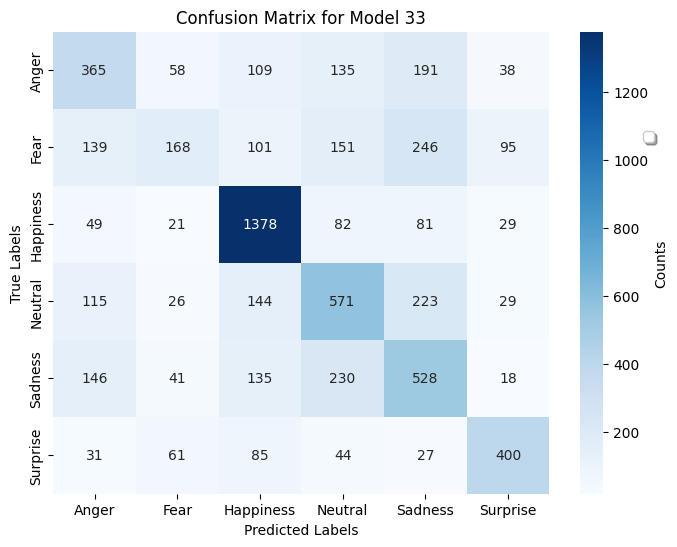

In [33]:
#Specify the model (for the title)
model_name = "Model 33"

# Label mapping
label_mapping = {
    0: 'Anger',
    1: 'Fear',
    2: 'Happiness',
    3: 'Neutral',
    4: 'Sadness',
    5: 'Surprise'
}

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())

plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Get the current Axes object from the plot
ax = plt.gca()

# Create a colorbar based on the mappable (heatmap)
cbar = ax.collections[0].colorbar
cbar.set_label('Counts')

# Add legend
plt.legend(label_mapping.values(), loc='upper center', bbox_to_anchor=(1.2, 0.8), shadow=True, ncol=1)

plt.show()

It looks like the model is having problem in identifyng fear, especially it missclissifies fear for anger, happiness, neutrality, and especially sadness. Mistaking fear for happiness shouldn't be happening, since the two emotions have very different representations so the model has a huge margin of improvement.

## Conclusions

### Observations

Using both grid seatch and stratified K fold validation made the training too long, especially for the resources at our disposal. Therefore, we should at least restrict the range of parameters for the search or consider using only one of the two approach. They affect different parts of the training and they are not mutually exclusive, but they both add training time, especially grid search, which is quite computationally expensive.

The models resulted a bit unspatble, and the results are better in the [previous notebook](https://www.kaggle.com/code/gabrielenoaro/emotion-classification-from-faces-cnn-part-3). An alternative to what we have done could have been applying grid search to the previous training, without stratified K-fold, to finetune the hyperparameters without altering the nature of the dataset.

### Limitations with the data

The data is one of the  major bottlenecks in this experiemnt. As said in the first notebook of the series, if there are missclassified images in the original data, that may lead to errors in the training. Also, mixed emotions (e.g., surprise + fear, surprise + happiness) can confuse the model as well. Also the fact that some emotions have similar traits made the learning process more difficult (e.g., Neutral Vs Sadness), and it would be useful to use this generic model as a base model to train more specialized models aimed at detecting the difference between such emotions (through the identification of microexpressions).

Another challenge was that the majority of images were images portraing actors interpreting an emotion. While it looks like the majortiy of good actors did a good job in displaying the emotion, some representation may not have looked authentic, with incomplete and to genuine microexpressions. To reduce the risk of encountering these two challenges we could access to bigger datasets (to increasing the chance of good samples outnumbering bad samples), and higher quality more controlled datasets. A further study could also take the output model from this study and use it as a pre-trained model to classify genuine Vs faked emotions from pictures.

When loading the data we removed duplicates, mixed data from different sources (increasing the variance in gender, etnic diversity, angles, and styles), and augmented data to reduce overfitting and balance the classes, so each class got the same amount of items. However, we did not aumented the images from the "Happiness" folder, because it had the most items, so further study could do some augmentation there too to reduce overfitting (still making sure that each label has the same number of items).

As future steps we should try adding more images through data augmentation, and test if that helps in reducing overfitting. We could also experiment removing neutrality, our most mistaken class (mistaken for sadness and viceversa), and see how accuracy dramatically increases. However, by removing a class, we would also drastically change the goal of our models. Also, by removing neutrality, if the model was to be applied in a life scenarion, it would start mistake neutral expression for sadness.

Last but not least, we could not use transfer learning with the models present in the PyTorch Hub, because the images in some of the sets were to small: 48X48 px when the required minimum was 224X224 images. Moreover, the small side of images may have also caused the more complex models to underfit the data. In future experiemnt we should seek images that are at least 224X224 px of size.

### Next steps

Next we should review the code again to see some opportunities for improvement. For example reducing the range of hyperparameters in grid search and closing the training loop. Indeed, adding both grid search and stratified K-fold validation added too much computational strain during the training of the model, even if utilizing CUDA with GPUs, especially because we used also thousands of images to train the models. We could also try with data of higher quality, and images that are at least 224X224 (tweaking our models) to add also a pre-trained model from the PyTorch Hub and benefit from transfer-learning. For example, if transfer learning could help the model recognize faces easily, the new model could better focus on specializing on facial microexpressions.